# TensorFlow deep dive
This week we will going inside the workings of Tensorflow to understand some of the implementation details as well as some more adavanced techniques. Conceptual understanding of how Tensorflow works can help in debugging your code.

##⏰ Exercise
There may be bugs in this notebook. Please find and fix them!

## Resources
1. [CSC321 slides](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
2. [Custom Training walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#tensorflow_programming)
3. [The Functional API](https://keras.io/guides/functional_api/)
4. [Writing your own callback](https://keras.io/guides/writing_your_own_callbacks/)
5. [Amazing autodiff explainer](https://www.youtube.com/watch?v=wG_nF1awSSY)

In [1]:
import tensorflow as tf
import numpy as np

## Tensors

TensorFlow is an infrastructure layer for differentiable programming.
At its heart, it's a framework for manipulating N-dimensional arrays (tensors),
much like NumPy.

However, there are three key differences between NumPy and TensorFlow:

- TensorFlow can leverage hardware accelerators such as GPUs and TPUs.
- TensorFlow can automatically compute the gradient of arbitrary differentiable tensor expressions.
- TensorFlow computation can be distributed to large numbers of devices on a single machine, and large number of
machines (potentially with multiple devices each).

Let's take a look at the object that is at the core of TensorFlow: the Tensor.

Here's a constant tensor:

In [2]:
import tensorflow as tf
x = tf.constant([[5, 2], [1, 3]])
print(x)

Metal device set to: tf.Tensor(
[[5 2]
 [1 3]], shape=(2, 2), dtype=int32)
Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-28 20:57:47.150188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 20:57:47.150354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


You can get its value as a NumPy array by calling `.numpy()`:

In [3]:
x.numpy()

array([[5, 2],
       [1, 3]], dtype=int32)

Much like a NumPy array, it features the attributes `dtype` and `shape`:

In [4]:
print("dtype:", x.dtype)
print("shape:", x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


A common way to create constant tensors is via `tf.ones` and `tf.zeros` (just like `np.ones` and `np.zeros`):

In [5]:
print(tf.ones(shape=(2, 1)))
print(tf.zeros(shape=(2, 1)))

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


You can also create random constant tensors:

In [6]:
x = tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)

x = tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype="int32")


## Variables

Variables are special tensors used to store mutable state. When something is mutable, it means that the value of that object can be changed or updated. So,we will use Variables for things such as the weights of a neural network.

You create a `Variable` using some initial value:

In [7]:
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)
print(a)


<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.27704275, -0.08301634],
       [-1.4391432 ,  0.8447572 ]], dtype=float32)>


You update the value of a `Variable` by using the methods `.assign(value)`, `.assign_add(increment)`, or `.assign_sub(decrement)`:

In [8]:
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)
print(a)

for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j]

added_value = tf.random.normal(shape=(2, 2))
a.assign_add(added_value)
print(added_value)
print(a)
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j] + added_value[i, j]

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.9874213 , -0.8751453 ],
       [ 0.64128494, -0.03301785]], dtype=float32)>
tf.Tensor(
[[-1.0088416   0.85940045]
 [-1.4712318  -0.08714572]], shape=(2, 2), dtype=float32)
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-2.996263  , -0.01574486],
       [-0.8299469 , -0.12016356]], dtype=float32)>


If you do not use the assign method, the `Variable` will not remain a `Variable`.

In [9]:
# a is Variable from above
print(a) # you can see it is a variable

# let's say we want to add a tensor to a
addition = tf.random.normal(shape=(2, 2))

# let's see what happens if we don't use the assign method
a = a + addition
print(a)

# it converts to a constant tensor!
# Using gradient tape introduced below will not track this tensor
# using a Variable directly like this at any point will cause similar behavior
# Once a Variable is 'evaluated' to a tensor, you will have re-run your
# initialization to get the Variable back.

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-2.996263  , -0.01574486],
       [-0.8299469 , -0.12016356]], dtype=float32)>
tf.Tensor(
[[-4.043505    0.08606432]
 [-1.7484736  -1.8703641 ]], shape=(2, 2), dtype=float32)


## Doing math in TensorFlow

If you've used NumPy, doing math in TensorFlow will look very familiar.
The main difference is that your TensorFlow code can run on GPU and TPU.

In [10]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

c = a + b
d = tf.square(c)
e = tf.exp(d)

print(a)
print(b)
print(c)
print(d)
print(e)

tf.Tensor(
[[0.560065  0.9603297]
 [0.8685211 0.7212865]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.15118583  0.7084114 ]
 [-0.2613254   0.02228578]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.7112508  1.6687411 ]
 [0.60719573 0.74357224]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.5058777  2.7846968 ]
 [0.36868665 0.55289966]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1.6584404 16.194908 ]
 [ 1.4458344  1.7382861]], shape=(2, 2), dtype=float32)


## Gradients

Here's another big difference with NumPy: you can automatically retrieve the gradient of any differentiable expression. 

Tensorflow using automatic differentiation to find gradients of expressions that use tensors. Specifically, it uses a reverse automatic differentiation. For this, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients. Please explore autodiff more through the resources provided.

*General Idea for Implementation:*
- Create a "tape" data structure that tracks the operations performed in computing a function
- Overload primitives to:
  - Add themselves to the tape when called
  - Compute gradients with respect to their local inputs
- Forward pass computes the function, and adds operations to the tape
- Reverse pass accumulates the local gradients using the chain rule

In practive you can just open a `GradientTape`, start "watching" a tensor via `tape.watch()`,
and compose a differentiable expression using this tensor as input:

In [11]:
a = 5*tf.ones(shape=(2, 2))
a = tf.constant([[1,2],[3,4]], dtype='float32')
a = tf.Variable([2,3], dtype='float32')
b = 6*tf.ones(shape=(1, 2))

print(a)
print(b)

print(4*3*3*3)
print(4*2*2*2)


with tf.GradientTape() as tape:
    tape.watch(a)  # Start recording the history of operations applied to `a`
    #c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
    c = tf.square(a) 
    c = tf.square(c) 
    print(c)
    # What's the gradient of `c` with respect to `a`?
    dc_da = tape.gradient(c, a)
    print(dc_da)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2., 3.], dtype=float32)>
tf.Tensor([[6. 6.]], shape=(1, 2), dtype=float32)
108
32
tf.Tensor([16. 81.], shape=(2,), dtype=float32)
tf.Tensor([ 32. 108.], shape=(2,), dtype=float32)


By default, variables are watched automatically, so you don't need to manually `watch` them:

In [12]:
a = tf.Variable(a)

with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor([0.31622776 0.44721356], shape=(2,), dtype=float32)


### Controlling what the tape watches

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

In [13]:
# A trainable variable
x0 = tf.Variable(3.0)
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2) + (x3**2)

print(y)

grad = tape.gradient(y, [x0, x1, x2, x3])


for g in grad:
  print(g)


# but this works:
with tf.GradientTape() as tape:
  y2 = (x0**2)

grad2 = tape.gradient(y2, x0)

print(grad2)

tf.Tensor(35.999992, shape=(), dtype=float32)
tf.Tensor(5.9999995, shape=(), dtype=float32)
None
None
None
tf.Tensor(5.9999995, shape=(), dtype=float32)


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

In [14]:
[var.name for var in tape.watched_variables()]

['Variable:0']

### Gradients with respect to a model

In most cases, you will want to calculate gradients with respect to a model's trainable variables.  Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code: 

In [15]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [16]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


## Advanced Autodiff

An autodiff system will convert our expression into a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). These elementary operations and fucntions are called primitives. Primitives have predefined routines to calculate their gradients.

This sequence of operations is converted into a computational graph. A computational graph simply turns each operation into a node and connects them through lines, called edges.
Say we want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where:

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$
The computation graph for this expression is shown in the figure below. 

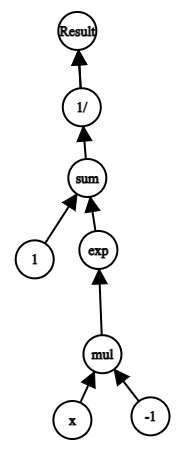

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are basic expressions for which we can easily compute the local gradients.

The input to this function is $x$, and the output is represented by node $s$. We wish compute the gradient of $s$ with respect to $x$, $\frac{\partial s}{\partial x}$. In order to make use of our intermediate computations, we can use the chain rule as follows:
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$

In reverse autodiff, to calculate gradient with respect to an input, we start at the Result and traverse the graph backward to our input. At each node, we will encounter a primitive function. We will calculate the derivative of each primitive along the way and multiply them all according to the chain rule to get the final value of the gradient.


In [17]:
def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid
    function using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the 
    # backward pass
    a = -x         # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b      # 1 + e^{-x} in denominator
    s = 1.0 / c    # Final result, 1.0 / (1 + e^{-x})
    
    # Backward pass
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx

# using gradient tape instead
def grad_sigmoid_automatic(x):
  a = tf.constant(x)
  with tf.GradientTape() as tape:
      tape.watch(a)  # Start recording the history of operations applied to `a`
      c = tf.math.sigmoid(a)
      # What's the gradient of `c` with respect to `a`?
      dc_da = tape.gradient(c, a)
  return dc_da

# Compare the results of manual and automatic gradient functions:
print(grad_sigmoid_automatic(2.0))
print(grad_sigmoid_manual(2.0))

tf.Tensor(0.10499353, shape=(), dtype=float32)
0.1049935854035065


Also, note that you can compute higher-order derivatives by nesting tapes:

In [18]:
print(a)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as tape:
        c = tf.sqrt(tf.square(a) + tf.square(b))
        dc_da = tape.gradient(c, a)
        print(dc_da)
    d2c_da2 = outer_tape.gradient(dc_da, a)
    print(d2c_da2)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2., 3.], dtype=float32)>
tf.Tensor([0.31622776 0.44721356], shape=(2,), dtype=float32)
tf.Tensor([0.1423025  0.11925695], shape=(2,), dtype=float32)


You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

In [19]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

# and then call again if you want to get the gradient with respect to x
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())

18.0
108.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

In [20]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [21]:
del tape   # Drop the reference to the tape

## The Functional API review

To build deep learning models, we've seen so far how they can be composed functionally, like this (we call
it the "Functional API"):

In [22]:
# We use an `Input` object to describe the shape and dtype of the inputs.
# This is the deep learning equivalent of *declaring a type*.
# The shape argument is per-sample; it does not include the batch size.
# The functional API focused on defining per-sample transformations.
# The model we create will automatically batch the per-sample transformations,
# so that it can be called on batches of data.
inputs = tf.keras.Input(shape=(784,), dtype="float32")

# We call layers on these "type" objects
# and they return updated types (new shapes/dtypes).
x = tf.keras.layers.Dense(32, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10)(x)

# A functional `Model` can be defined by specifying inputs and outputs.
# A model is itself a layer like any other.
model = tf.keras.Model(inputs, outputs)

# Let's call our model on some data, for fun.
y = model(tf.ones((2, 784)))
assert y.shape == (2, 10)

# You can pass a `training` argument in `__call__`
# (it will get passed down to the Dropout layer).
y = model(tf.ones((2, 784)), training=True)

## Custom training loops


With gradient tapes, we can write our own training loops. This is particularly useful for more complex models, like GANs, where we need a much higher control over which weights are trained. 

First let us prepare the MNIST dataset.

In [23]:
# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000,784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(16)

Then we set up a loss function and so far, we have been using the `.compile()` and `.fit()` methods for training the model.

In [24]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='sgd', loss=loss_fn, metrics=['acc'])
model.fit(dataset, epochs=2)

Epoch 1/2


2023-02-28 20:58:43.451886: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-28 20:58:43.452378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 21s 5ms/step - loss: 0.8101 - acc: 0.7538
Epoch 2/2
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4556 - acc: 0.8680


We can replace these with a custom training loop like this:

In [25]:
# Let's demonstrate how to use a training loop.

# Loss and optimizer.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for epochs in range(2):
  for step, (x, y) in enumerate(dataset):
      with tf.GradientTape() as tape:
          # Forward pass.
          logits = model(x)
          # External loss value for this batch.
          loss = loss_fn(y, logits)
          # Get gradients of the loss wrt the weights.
          gradients = tape.gradient(loss, model.trainable_weights)

      # Update the weights of our linear layer.
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))

      # Logging
      if step % 100 == 0:
          print("Step:", step, "Loss:", float(loss))

Step: 0 Loss: 0.25871482491493225
Step: 100 Loss: 0.09273234009742737
Step: 200 Loss: 0.2915576994419098
Step: 300 Loss: 0.5641614198684692
Step: 400 Loss: 0.24844102561473846
Step: 500 Loss: 0.0930514708161354
Step: 600 Loss: 0.07068446278572083
Step: 700 Loss: 0.09715358167886734
Step: 800 Loss: 0.07388998568058014
Step: 900 Loss: 0.14864414930343628
Step: 1000 Loss: 0.32591161131858826
Step: 1100 Loss: 0.38956910371780396
Step: 1200 Loss: 0.5928006768226624
Step: 1300 Loss: 0.639584481716156
Step: 1400 Loss: 0.19506604969501495
Step: 1500 Loss: 0.0578753724694252
Step: 1600 Loss: 0.20680800080299377
Step: 1700 Loss: 0.3058369755744934
Step: 1800 Loss: 0.2530142664909363
Step: 1900 Loss: 0.28684407472610474
Step: 2000 Loss: 0.3055097162723541
Step: 2100 Loss: 0.5274989604949951
Step: 2200 Loss: 0.22680245339870453
Step: 2300 Loss: 0.4784732758998871
Step: 2400 Loss: 0.039486076682806015
Step: 2500 Loss: 0.19443649053573608
Step: 2600 Loss: 0.3305051922798157
Step: 2700 Loss: 0.355609

For more information also check out the guides from tensorflow website: [1](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#tensorflow_programming) and [2](https://www.tensorflow.org/guide/basic_training_loops). 

## Keeping track of performance metrics

### With `fit()` method

As you're training a model, you want to keep track of metrics such as classification
accuracy, precision, recall, AUC, etc. Besides, you want to monitor these metrics not
 only on the training data, but also on a validation set.

**Monitoring metrics**

You can pass a list of metric objects to `compile()`, like this:


In [26]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
history = model.fit(dataset, epochs=1)

2023-02-28 21:00:09.105260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 24s 6ms/step - loss: 2.1451 - acc: 0.5986


**Passing validation data to `fit()`**

You can pass validation data to `fit()` to monitor your validation loss & validation
 metrics. Validation metrics get reported at the end of each epoch.

In [27]:
val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000,784).astype("float32") / 255, y_test)
) # again we hid a bug here. were you able to correct it?
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(16)    

history = model.fit(dataset, epochs=1, validation_data=val_dataset)

3749/3750 [============================>.] - ETA: 0s - loss: 2.2408 - acc: 0.5027

2023-02-28 21:00:57.731739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 26s 7ms/step - loss: 2.2408 - acc: 0.5027 - val_loss: 2.3026 - val_acc: 0.6331


### With custom loops

Keras offers a broad range of built-in metrics, like `tf.keras.metrics.AUC`
or `tf.keras.metrics.PrecisionAtRecall`. It's also easy to create your
own metrics in a few lines of code.

To use a metric in a custom training loop, you would:

- Instantiate the metric object, e.g. `metric = tf.keras.metrics.AUC()`
- Call its `metric.udpate_state(targets, predictions)` method for each batch of data
- Query its result via `metric.result()`
- Reset the metric's state at the end of an epoch or at the start of an evaluation via
`metric.reset_state()`

Here's a simple example:

In [28]:
# Instantiate a metric object
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Prepare our loss, and optimizer.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(2):
    # Iterate over the batches of a dataset.
    for step, (x, y) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            # Compute the loss value for this batch.
            loss_value = loss_fn(y, logits)

        # Update the state of the `accuracy` metric.
        accuracy.update_state(y, logits)

        # Update the weights of the model to minimize the loss value.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Logging the current accuracy value so far.
        if step % 200 == 0:
            print("Epoch:", epoch, "Step:", step)
            print("Total running accuracy so far: %.3f" % accuracy.result())

    # Reset the metric's state at the end of an epoch
    accuracy.reset_state()

Epoch: 0 Step: 0
Total running accuracy so far: 0.688
Epoch: 0 Step: 200
Total running accuracy so far: 0.890
Epoch: 0 Step: 400
Total running accuracy so far: 0.905
Epoch: 0 Step: 600
Total running accuracy so far: 0.905
Epoch: 0 Step: 800
Total running accuracy so far: 0.910
Epoch: 0 Step: 1000
Total running accuracy so far: 0.909
Epoch: 0 Step: 1200
Total running accuracy so far: 0.912
Epoch: 0 Step: 1400
Total running accuracy so far: 0.915
Epoch: 0 Step: 1600
Total running accuracy so far: 0.916
Epoch: 0 Step: 1800
Total running accuracy so far: 0.918
Epoch: 0 Step: 2000
Total running accuracy so far: 0.918
Epoch: 0 Step: 2200
Total running accuracy so far: 0.920
Epoch: 0 Step: 2400
Total running accuracy so far: 0.921
Epoch: 0 Step: 2600
Total running accuracy so far: 0.922
Epoch: 0 Step: 2800
Total running accuracy so far: 0.922
Epoch: 0 Step: 3000
Total running accuracy so far: 0.923
Epoch: 0 Step: 3200
Total running accuracy so far: 0.924
Epoch: 0 Step: 3400
Total running accu

## Using callbacks for checkpointing (and more)

If training goes on for more than a few minutes, it's important to save your model at
 regular intervals during training. You can then use your saved models
to restart training in case your training process crashes (this is important for
multi-worker distributed training, since with many workers at least one of them is
 bound to fail at some point).

An important feature of Keras is **callbacks**, configured in `fit()`. Callbacks are
 objects that get called by the model at different point during training, in particular:

- At the beginning and end of each batch
- At the beginning and end of each epoch

Callbacks are a way to make model trainable entirely scriptable.

You can use callbacks to periodically save your model. Here's a simple example: a
 `ModelCheckpoint` callback
configured to save the model at the end of every epoch. The filename will include the
 current epoch.

```python
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='path/to/my/model_{epoch}',
        save_freq='epoch')
]
model.fit(dataset, epochs=2, callbacks=callbacks)
```

You can also use callbacks to do things like periodically changing the learning of your
optimizer, streaming metrics to a Slack bot, sending yourself an email notification
 when training is complete, etc.

For detailed overview of what callbacks are available and how to write your own, see the
[guide to writing custom callbacks](https://keras.io/guides/writing_your_own_callbacks/).

#⏰ Exercise: using autodiff to calculate square roots
We have a very powerful tool in autodiff so let us use it on a problem that you can solve using only pen and paper.
To find the square root of a number $a$, we can solve the equation:
$$ f(x) = x^2-a = 0$$
To approximate the roots of $f(x)$, we can start with a guess $x_n$. Then, our next guess should be:
$$ x_{n+1} = x_n - \frac{f(x)}{f'(x)}$$
And we repeat this process until our guesses do not change very much.
Now, we will implement this with autodiff.

Let's say we want to calculate the square root of a number `a`. First initialize a `Variable` with a random value.

In [29]:
a = tf.constant(26.0, name='a') # pick a number and make it a tf Constant (make sure it is a float)
x = tf.Variable(tf.random.normal(shape=(1,1)), name='x') # tf Variable that is randomly initialized

Next, write an expression in tensorflow for $f(x)$

In [30]:
f = tf.square(x) - a # f(x)

Now use this expression inside a gradient tape to calculate its derivative and find the updated guess. Remeber to update a tf Variable, you should call the `assign` method.

In [31]:
with tf.GradientTape() as tape:
    # expression for f(x)
    f = tf.square(x) - a
    # derivative of f(x)
    grad = tape.gradient(f, x)
# write the update rule using f(x) and f'(x)
x.assign_sub(f/grad)

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[17.562355]], dtype=float32)>

Put is all together and run this in a loop for a number of iterations, and print the guess after each iteration.

In [32]:
a = tf.constant(26.0, name='a') # pick a number and make it a tf Constant (make sure it is a float)
x = tf.Variable(tf.random.normal(shape=(1,1)), name='x') # tf Variable that is randomly initialized
f = tf.square(x) - a # f(x)

for i in range(10):
    with tf.GradientTape() as tape:
        # expression for f(x)
        f = tf.square(x) - a
        # derivative of f(x)
        grad = tape.gradient(f, x)
    # write the update rule using f(x) and f'(x)
    x.assign_sub(f/grad)
    # print guess
    print(x.numpy())

[[-7.195348]]
[[-5.404397]]
[[-5.1076474]]
[[-5.0990267]]
[[-5.0990195]]
[[-5.0990195]]
[[-5.0990195]]
[[-5.0990195]]
[[-5.0990195]]
[[-5.0990195]]
